In [2]:
import os
os.chdir(os.path.join(os.getcwd(), "depreciated\\kalman"))
import numpy as np
import matplotlib.pyplot as plt
from probDE.car.car_init import zero_pad, root_gen, car_initial_draw, car_state
from kalman_ode_higher import kalman_ode_higher
from probDE.cython.kalman_ode_higher import kalman_ode_higher as kalman_ode_higher_cy
#from linalg.mat_mult import mat_mult, mat_vec_mult

In [2]:
%load_ext Cython

In [6]:
%%cython
from libc.math cimport sin
import numpy as np
cimport numpy as np

cpdef ode_fun(double[::1] x_t, double t, theta=None):
    return sin(2*t) - x_t[0]

cpdef rand_mat(int n, int p, bint pd=True):
    cdef np.ndarray[np.double_t, ndim=2] V = np.zeros((p, n), order='F')
    V[:] = np.random.randn(p, n)
    if (p == n) and pd:
        V[:] = np.matmul(V, V.T)
    return V

In [7]:
def chk_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

def chk_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

In [8]:
n_steps = 50
n_eval = n_steps-1
q = 2
p = q+2
tmin = 0
tmax = 10
delta_t = np.array([(tmax-tmin)*1/n_steps])
w = np.array([0. , 0., 1.])
wgt_meas = zero_pad(w, p)
x0 = np.array([-1., 0., 0.])
x0 = np.array([-1.0, 0.0, ode_fun(x0, 0)]) #Initial state
r0 = 500
sigma = 0.5
roots = root_gen(r0, p) #Generate roots to draw x^{(3)}_0
x0_state = car_initial_draw(roots, sigma, x0, p)
wgt_state, var_state = car_state(delta_t, roots, sigma) 
mu_state = np.zeros(p)
z_state_sim = rand_mat(2*n_steps, p)

Yn_chk_mean, Yn_chk_var = kalman_ode_higher(ode_fun, x0_state, tmin, tmax, n_eval, 
                                            wgt_state, mu_state, var_state, wgt_meas, z_state_sim)

In [9]:
Yn_chk_mean2, Yn_chk_var2 = kalman_ode_higher_cy(ode_fun, x0_state, tmin, tmax, n_eval, 
                                               wgt_state, mu_state, var_state, 
                                               wgt_meas, z_state_sim)

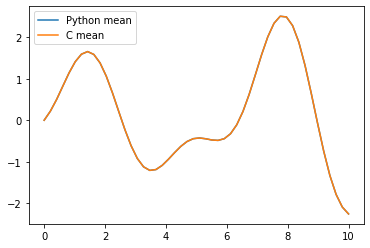

In [10]:
tseq = np.linspace(tmin, tmax, n_steps)
plt.plot(tseq, Yn_chk_mean[:, 1], label = 'Python mean')
#plt.plot(tseq, Yn[:, 1], label = 'Python sample')
plt.plot(tseq, Yn_chk_mean2[1], label = 'C mean')
#plt.plot(tseq, Yn2[1], label = 'C sample')
plt.legend(loc='upper left')

## Python, Cython, Odeint Timings

In [11]:
py = %timeit -o -n 100 Yn_chk_mean, Yn_chk_var = \
    kalman_ode_higher(ode_fun, x0_state, tmin, tmax, n_eval, wgt_state, mu_state, var_state, wgt_meas, z_state_sim)

8.25 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
cy = %timeit -o -n 100 Yn_chk_mean2, Yn_chk_var2 = \
    kalman_ode_higher_cy(ode_fun, x0_state, tmin, tmax, n_eval, wgt_state, mu_state, var_state, wgt_meas, z_state_sim)

2.04 ms ± 81.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
py.average/cy.average

4.047108033500052

In [14]:
from scipy import integrate
from math import sin
def f(x_t, t):
    return [x_t[1], sin(2*t) - x_t[0]]

In [15]:
ode = %timeit -o ode = integrate.odeint(f, [-1, 0], tseq)
#cy.average/ode.average

513 µs ± 4.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Pre-allocated Memorization

In [17]:
from kalman_ode_solve_py import kalman_ode_solve_py
from probDE.cython.kalman_ode_solve_cy import kalman_ode_solve_cy

In [18]:
# argumgents for kalman_filter and kalman_smooth
dim_meas = 1
dim_state = p
DTYPE = np.double
mu_meas = np.zeros(dim_meas, dtype=DTYPE, order='F')
var_meass = np.zeros((dim_meas, dim_meas, n_steps),dtype=DTYPE, order='F')
x_meass = np.zeros((dim_meas, n_steps), dtype=DTYPE, order='F')
mu_state_filts = np.zeros((dim_state, n_steps),dtype=DTYPE, order='F')
var_state_filts = np.zeros((dim_state, dim_state, n_steps),dtype=DTYPE, order='F')
mu_state_preds = np.zeros((dim_state, n_steps), dtype=DTYPE, order='F')
var_state_preds = np.zeros((dim_state, dim_state, n_steps), dtype=DTYPE, order='F')
mu_state_smooths = np.zeros((dim_state, n_steps), dtype=DTYPE, order='F')
var_state_smooths = np.zeros((dim_state, dim_state, n_steps),dtype=DTYPE, order='F')
x_state_smooths = np.zeros((dim_state, n_steps),dtype=DTYPE, order='F')
x_state_tt = np.zeros(dim_state, dtype=DTYPE, order='F') #Temporary state simulation for interrogation
var_state_meas = np.zeros((dim_meas, dim_state),dtype=DTYPE, order='F') #Temporary matrix for multi_dot
x_meas_ = np.zeros(dim_meas, dtype=DTYPE, order='F') #Temporary for matrix vector multi

In [19]:
solve_py = %timeit -o -n 100 _, _ = \
    kalman_ode_solve_py(ode_fun, x0_state, tmin, tmax, n_eval, wgt_state, mu_state, var_state, wgt_meas, z_state_sim, \
                       mu_meas, var_meass, x_meass, mu_state_filts, var_state_filts, mu_state_preds, \
                       var_state_preds, mu_state_smooths, var_state_smooths, x_state_smooths, x_state_tt)

8.72 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
solve_cy = %timeit -o -n 100 _, _ = \
    kalman_ode_solve_cy(ode_fun, x0_state, tmin, tmax, n_eval, wgt_state, mu_state, var_state, wgt_meas, z_state_sim, mu_meas, \
                        var_meass, x_meass, mu_state_filts, var_state_filts, mu_state_preds, var_state_preds, \
                        mu_state_smooths, var_state_smooths, x_state_smooths, x_state_tt, var_state_meas, x_meas_)

4.8 ms ± 73.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Offline

In [21]:
from kalman_ode_offline_py import kalman_ode_offline_py
from probDE.cython.kalman_ode_offline_cy import kalman_ode_offline_cy

In [22]:
offline_cy = %timeit -o -n 100 _, _ = \
    kalman_ode_offline_cy(ode_fun, x0_state, tmin, tmax, n_eval, wgt_state, mu_state, var_state, wgt_meas, z_state_sim, \
                          x_meass, offline=True)

2.11 ms ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
offline_py = %timeit -o -n 100 _, _ = \
    kalman_ode_offline_py(ode_fun, x0_state, tmin, tmax, n_eval, wgt_state, mu_state, var_state, wgt_meas, z_state_sim, \
                          x_meass, filter_only=True, offline=True)

3.99 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## C++ allocated memory


In [24]:
from probDE.cython.KalmanTest.kalmantest import KalmanTest

In [25]:
# argumgents for kalman_filter and kalman_smooth
dim_meas = 1
dim_state = p
DTYPE = np.double
mu_state_smooths = np.zeros((dim_state, n_steps), dtype=DTYPE, order='F')
var_state_smooths = np.zeros((dim_state, dim_state, n_steps),dtype=DTYPE, order='F')
ktest = KalmanTest(dim_meas, dim_state, n_steps)

In [26]:
kalmantest_cy = %timeit -o -n 100 ktest.filter_smooth(mu_state_smooths, var_state_smooths, x0_state, wgt_state, mu_state, var_state, wgt_meas, x_meass, z_state_sim)

108 µs ± 6.43 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Blas/Lapack

In [ ]:
def rel_err(X1, X2):
    """Relative error between two numpy arrays."""
    return np.max(np.abs((X1.ravel() - X2.ravel())/X1.ravel()))

In [ ]:
m = np.random.randint(2,10)
n = np.random.randint(2,10)
A = np.array(np.random.rand(m,n), order='F')
x = np.random.rand(n)
y = np.zeros(m, order='F')

In [ ]:
mat_vec_mult(A, x, y)
np.testing.assert_almost_equal(rel_err(A.dot(x), y), 0.0)

In [ ]:
m = np.random.randint(2,10)
k = np.random.randint(2,10)
n = np.random.randint(2,10)
A = np.array(np.random.rand(m,k), order='F')
B = np.array(np.random.rand(k,n), order='F')
C = np.zeros((m,n), order='F')

In [ ]:
mat_mult(A, B, C)
np.testing.assert_almost_equal(rel_err(np.matmul(A, B), C), 0.0)